## 7.6 残差网络(ResNet)

### 7.6.1 函数类

包括了非嵌套函数类和嵌套函数类，非嵌套的函数类可能越来越远离我们需要找到的函数映射，但是嵌套函数类则不会。两者如下所示。

![](../images/7-6-1.svg)

何恺明（校友校友）提出的残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。

### 7.6.2 残差块

下图展示了残差块的模样，当理想映射$f(\bm{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。

![](../images/7-6-2.svg)

ResNet沿用了VGG完整的$3\times 3$卷积层设计，但是如果需要改变通道数，则需要引入一个额外的$1\times 1$卷积层来进行变换，实现如下。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  #@save
    """残差块"""
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            # 这里由于stride的存在，可以直接用1x1卷积来改变通道数和尺寸
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

上面的这个类实现了下面两个残差块。

![](../images/7-6-3.svg)

下面分别查看输入和输出一致以及不一致的情况。

In [2]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [3]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 7.6.3 ResNet模型

ResNet的主要结构和在[7.4节](7-4.ipynb)中所介绍的GoogleNet是类似的，不同在于ResNet在每个卷积层后增加了批量规范化层。

In [4]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

下面定义一下4个残差块组成的模块

In [5]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            # 通道和分辨率减半
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet中加入所有残差块，这里每个模块使用两个残差块。

In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

在最后加入全局平均汇聚层，以及全连接层输出。

In [7]:
net = nn.Sequential(
    b1,
    b2,
    b3,
    b4,
    b5, 
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10),
)

下面是一个有18层的ResNet-18。

![](../images/7-6-4.svg)

训练之前还是看看通道和大小怎么变。

In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


### 7.6.4 训练模型

一样的

loss 0.014, train acc 0.996, test acc 0.913
7012.3 examples/sec on cuda:3


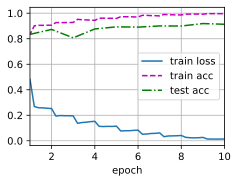

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(3))

### 7.6.5 小结

- 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
- 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
- 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
- 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。